In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:

def load_df(csv_path='C:\\Users\\Manoj Kumar\\Desktop\\kaggle\\project1\\train.csv\\train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
%%time
train_df = load_df()
test_df = load_df("C:\\Users\\Manoj Kumar\\Desktop\\kaggle\\project1\\test.csv\\test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
Wall time: 4min 36s


In [ ]:
train_df

In [4]:
train_df['date'].max()

20170801

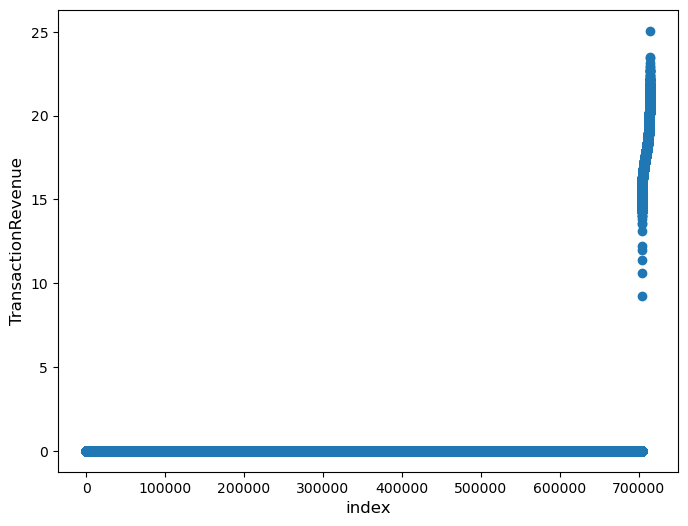

In [5]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [6]:
x=gdf[gdf["totals.transactionRevenue"]>0]
x.shape

(9996, 2)

In [7]:
gdf.shape

(714167, 2)

In [8]:
gdf.shape[1]

2

 The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

In [9]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


So the ratio of revenue generating customers to customers with no revenue is in the ratio os 1.3%

 Number of visitors and common visitors:

Now let us look at the number of unique visitors in the train and test set and also the number of common visitors.

In [10]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in test set :  617242  out of rows :  804684
Number of common visitors in train and test set :  7679


Columns with constant values:
Looks like there are quite a few features with constant value in the train set. Let us get the list of these features. As pointed by Svitlana in the comments below, let us not include the columns which has constant value and some null values.we can just drop them from our feature list and save some memory and time in our modeling process.

In [11]:
train_df

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [12]:
test_df

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.newVisits,totals.bounces,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Singapore,(not set),(not set),(not set),not available in demo dataset,myrepublic.com.sg,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,4,NaN,NaN,(not set),google,organic,(not provided),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Aragon,(not set),Zaragoza,not available in demo dataset,rima-tde.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,5,5,1,NaN,(not set),google,organic,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,France,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,sfr.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,7,7,1,NaN,(not set),google,organic,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in dem

In [13]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [11]:
train_df['device.browserSize'].nunique()

1

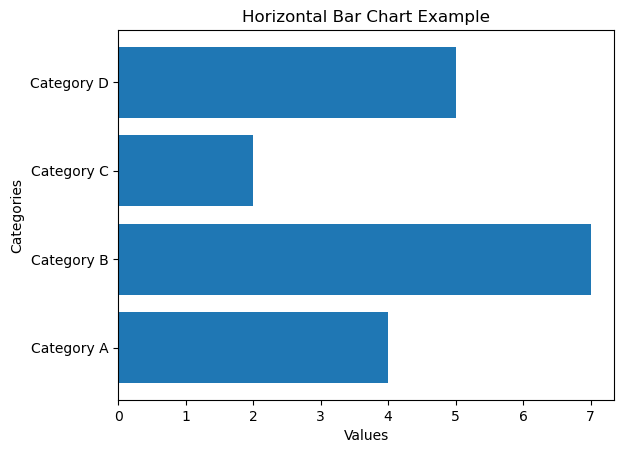

In [17]:
import matplotlib.pyplot as plt

# Example data
categories = ['Category A', 'Category B', 'Category C', 'Category D']
values = [4, 7, 2, 5]

# Creating the horizontal bar chart
plt.barh(categories, values)

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Categories')
plt.title('Horizontal Bar Chart Example')

# Display the plot
plt.show()

In [23]:
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

,count,count of non-zero revenue,mean
device.browser,,,
Chrome,620364,10353,1.335946e+08
Safari,182245,780,6.717626e+07
Firefox,37069,191,4.676247e+08
Internet Explorer,19375,109,7.573899e+07
Edge,10205,58,1.117753e+08
Android Webview,7865,6,1.914167e+07
Safari (in-app),6850,12,1.281417e+07
Opera Mini,6139,0,NaN
Opera,5643,5,4.307000e+07


In [ ]:
train_df

In [24]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace
# Device Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



inferences:

    Device browser distribution looks similar on both the count and count of non-zero revenue plots
    On the device category front, desktop seem to have higher percentage of non-zero revenue counts compared to mobile devices.
    In device operating system, though the number of counts is more from windows, the number of counts where revenue is not zero is more for Macintosh.
    Chrome OS also has higher percentage of non-zero revenue counts
    On the mobile OS side, iOS has more percentage of non-zero revenue counts compared to Android


In [25]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   channelGrouping                                    903653 non-null  object 
 1   date                                               903653 non-null  object 
 2   fullVisitorId                                      903653 non-null  object 
 3   sessionId                                          903653 non-null  object 
 4   socialEngagementType                               903653 non-null  object 
 5   visitId                                            903653 non-null  int64  
 6   visitNumber                                        903653 non-null  int64  
 7   visitStartTime                                     903653 non-null  int64  
 8   device.browser                                     903653 non-null  object

In [15]:
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = test_df.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In [26]:
# Continent
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Inferences:

    On the continent plot, we can see that America has both higher number of counts as well as highest number of counts where the revenue is non-zero
    Though Asia and Europe has high number of counts, the number of non-zero revenue counts from these continents are comparatively low.
    We can infer the first two points from the sub-continents plot too.
    If the network domain is "unknown.unknown" rather than "(not set)", then the number of counts with non-zero revenue tend to be lower.


In [27]:
# Continent
cnt_srs = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Inferences:

    In the traffic source plot, though Youtube has high number of counts in the dataset, the number of non-zero revenue counts are very less.
    Google plex has a high ratio of non-zero revenue count to total count in the traffic source plot.
    On the traffic source medium, "referral" has more number of non-zero revenue count compared to "organic" medium.

Visitor Profile:

Now let us look at the visitor profile variables like number of pageviews by the visitor, number of hits by the visitor and see how they look.


In [28]:
# Page views
cnt_srs = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead





Inferences:

    Both these variables look very predictive
    Count plot shows decreasing nature i.e. we have a very high total count for less number of hits and page views per visitor transaction and the overall count decreases when the number of hits per visitor transaction increases.
    On the other hand, we can clearly see that when the number of hits / pageviews per visitor transaction increases, we see that there is a high number of non-zero revenue counts.

Baseline Model:

Now let us build a baseline model on this dataset. Before we start building models, let us look at the variable names which are there in train dataset and not in test dataset.


In [19]:
print("Variables not in test but in train : ", set(train_df.columns).difference(set(test_df.columns)))

Variables not in test but in train :  {'trafficSource.campaignCode', 'totals.transactionRevenue'}


So apart from target variable, there is one more variable "trafficSource.campaignCode" not present in test dataset. So we need to remove this variable while building models. Also we can drop the constant variables which we got earlier.
Also we can remove the "sessionId" as it is a unique identifier of the visit.


In [20]:
cols_to_drop = const_cols + ['sessionId']

train_df = train_df.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)

In [21]:
train_df.head()


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent
0,Organic Search,2016-09-02,1131660440785968503,1472830385,1,1472830385,Chrome,Windows,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,2016-09-02,377306020877927890,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2016-09-02,3895546263509774583,1472865386,1,1472865386,Chrome,Windows,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2016-09-02,4763447161404445595,1472881213,1,1472881213,UC Browser,Linux,False,desktop,...,organic,google + online,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2016-09-02,27294437909732085,1472822600,2,1472822600,Chrome,Android,True,mobile,...,organic,(not provided),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
max_date = train_df['date'].max()
max_date

In [22]:
test_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,2017-10-16,6167871330617112363,1508151024,2,1508151024,Chrome,Macintosh,False,desktop,...,organic,(not provided),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,2017-10-16,0643697640977915618,1508175522,1,1508175522,Chrome,Windows,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2017-10-16,6059383810968229466,1508143220,1,1508143220,Chrome,Macintosh,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2017-10-16,2376720078563423631,1508193530,1,1508193530,Safari,iOS,True,mobile,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2017-10-16,2314544520795440038,1508217442,1,1508217442,Safari,Macintosh,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
min_date = test_df['date'].min()
min_date

datetime.date(2017, 8, 2)

In [24]:
# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

In [ ]:
train_df.shape

In [ ]:
test_df.shape

In [26]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent
0,Organic Search,2016-09-02,1131660440785968503,1472830385,1,1472830385,Chrome,Windows,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,2016-09-02,377306020877927890,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2016-09-02,3895546263509774583,1472865386,1,1472865386,Chrome,Windows,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2016-09-02,4763447161404445595,1472881213,1,1472881213,UC Browser,Linux,False,desktop,...,organic,google + online,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2016-09-02,27294437909732085,1472822600,2,1472822600,Chrome,Android,True,mobile,...,organic,(not provided),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
# Unwanted columns
unwanted_columns = ['channelGrouping','trafficSource.campaign','trafficSource.source','trafficSource.medium',
                    'trafficSource.keyword','trafficSource.isTrueDirect','trafficSource.referralPath','trafficSource.adwordsClickInfo.page',
                    'trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.adNetworkType','trafficSource.adwordsClickInfo.isVideoAd',
                    'trafficSource.adContent' ]

train = train_df.drop(unwanted_columns, axis=1)
test = test_df.drop(unwanted_columns, axis=1)
# Constant columns
constant_columns = [c for c in train.columns if train[c].nunique()<=1]
print('Columns with constant values: ', constant_columns)
train = train.drop(constant_columns, axis=1)
test = test.drop(constant_columns, axis=1)
# Columns with more than 50% null data
high_null_columns = [c for c in train.columns if train[c].count()<=len(train) * 0.5]
print('Columns more than 50% null values: ', high_null_columns)
train = train.drop(high_null_columns, axis=1)
test = test.drop(high_null_columns, axis=1)

Columns with constant values:  ['totals.bounces', 'totals.newVisits']
Columns more than 50% null values:  []


In [96]:
train.shape

(903653, 19)

In [97]:
category_counts=train['geoNetwork.country'].value_counts()
# Create a mapping dictionary with frequencies
frequency_mapping = category_counts.to_dict()
# Apply frequency encoding to the 'Category' column
train['geoNetwork.country'] = train['geoNetwork.country'].map(frequency_mapping)
category_counts

geoNetwork.country
United States            364744
India                     51140
United Kingdom            37393
Canada                    25869
Vietnam                   24598
                          ...  
St. Pierre & Miquelon         1
Anguilla                      1
American Samoa                1
Åland Islands                 1
St. Barthélemy                1
Name: count, Length: 222, dtype: int64

In [98]:
category_counts=train['geoNetwork.region'].value_counts()
# Create a mapping dictionary with frequencies
frequency_mapping = category_counts.to_dict()
# Apply frequency encoding to the 'Category' column
train['geoNetwork.region'] = train['geoNetwork.region'].map(frequency_mapping)
category_counts

geoNetwork.region
not available in demo dataset    508229
California                       107495
(not set)                         27827
New York                          26433
England                           13198
                                  ...  
Leiria District                       6
Assam                                 6
Kumamoto Prefecture                   5
San Salvador Department               5
Montana                               3
Name: count, Length: 376, dtype: int64

In [99]:
category_counts=train['geoNetwork.city'].value_counts()
# Create a mapping dictionary with frequencies
frequency_mapping = category_counts.to_dict()
# Apply frequency encoding to the 'Category' column
train['geoNetwork.city'] = train['geoNetwork.city'].map(frequency_mapping)
category_counts

geoNetwork.city
not available in demo dataset    508229
Mountain View                     40884
(not set)                         34262
New York                          26371
San Francisco                     20329
                                  ...  
Douglasville                          5
San Salvador                          5
Daly City                             4
Boise                                 3
Bozeman                               3
Name: count, Length: 649, dtype: int64

In [100]:
category_counts=train['geoNetwork.networkDomain'].value_counts()
# Create a mapping dictionary with frequencies
frequency_mapping = category_counts.to_dict()
# Apply frequency encoding to the 'Category' column
train['geoNetwork.networkDomain'] = train['geoNetwork.networkDomain'].map(frequency_mapping)
category_counts

geoNetwork.networkDomain
(not set)            244881
unknown.unknown      146034
comcast.net           28743
rr.com                14827
verizon.net           13637
                      ...  
panasonic.jp              1
flair.cz                  1
kwanglimyhi.co.id         1
nursat.kz                 1
xpressgt.co.za            1
Name: count, Length: 28064, dtype: int64

In [101]:
train.head()

,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.transactionRevenue
0,2016-09-02,1131660440785968503,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,20522,1321,(not set),1321,13228,1,1,0.0
1,2016-09-02,377306020877927890,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,12698,508229,not available in demo dataset,508229,318,1,1,0.0
2,2016-09-02,3895546263509774583,1472865386,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,11658,2937,(not set),2593,146034,1,1,0.0
3,2016-09-02,4763447161404445595,1472881213,1,1472881213,UC Browser,Linux,False,desktop,Asia,Southeast Asia,9273,508229,not available in demo dataset,508229,146034,1,1,0.0
4,2016-09-02,27294437909732085,1472822600,2,1472822600,Chrome,Android,True,mobile,Europe,Northern Europe,37393,508229,not available in demo dataset,508229,146034,1,1,0.0


In [102]:
categorical_features = ['device.browser','geoNetwork.continent','device.operatingSystem','device.isMobile','device.deviceCategory'
                        ,'geoNetwork.subContinent','geoNetwork.metro',
                        ]

train = pd.get_dummies(train, columns=categorical_features)

In [ ]:
train

In [103]:
train1=train.drop('geoNetwork.subContinent_(not set)',axis=1)

In [37]:
# train1=train1.drop('device.operatingSystem_(not set)',axis=1)

KeyError: "['device.operatingSystem_(not set)'] not found in axis"

In [104]:
train1=train1.drop('geoNetwork.metro_(not set)',axis=1)
train1=train1.drop('geoNetwork.metro_not available in demo dataset',axis=1)

In [105]:
train1=train1.drop('device.browser_(not set)',axis=1)
train1=train1.drop('geoNetwork.continent_(not set)',axis=1)

In [106]:
# Assuming your DataFrame is named df
columns_to_remove = ['date', 'fullVisitorId']

# Drop the specified columns
train1= train1.drop(columns=columns_to_remove)

In [107]:
train1.drop('visitId',axis=1,inplace=True)

In [108]:
train1 = train1[train1['totals.transactionRevenue'] > 0]

In [109]:
# Replace NaN values with the median of each column
# train1 = train1.fillna(train1.median())
train1_y=train1['totals.transactionRevenue'].copy()
train1.drop('totals.transactionRevenue',axis=1,inplace=True)

(11515, 204)

In [110]:
train1.drop('visitStartTime',axis=1,inplace=True)


In [112]:
train1_y

752        37860000.0
753       306670000.0
799        68030000.0
802        26250000.0
859       574150000.0
             ...     
903302    335260000.0
903305    599950000.0
903314     30750000.0
903315     69390000.0
903317     74990000.0
Name: totals.transactionRevenue, Length: 11515, dtype: float64

In [64]:
from sklearn.model_selection import train_test_split


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,2017-10-16,6167871330617112363,1508151024,2,1508151024,Chrome,Macintosh,False,desktop,...,organic,(not provided),True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,2017-10-16,0643697640977915618,1508175522,1,1508175522,Chrome,Windows,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,2017-10-16,6059383810968229466,1508143220,1,1508143220,Chrome,Macintosh,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2017-10-16,2376720078563423631,1508193530,1,1508193530,Safari,iOS,True,mobile,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2017-10-16,2314544520795440038,1508217442,1,1508217442,Safari,Macintosh,False,desktop,...,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804679,Social,2018-04-21,9084225574121020383,1524358436,2,1524358436,Edge,Windows,False,desktop,...,referral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/intl/en/yt/about/,NaN
804680,Social,2018-04-21,6146210385566305056,1524317728,1,1524317728,Chrome,Android,True,mobile,...,referral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/yt/lineups/es/index.html,NaN
804681,Social,2018-04-21,7484543584006767361,1524364725,1,1524364725,Safari (in-app),iOS,True,mobile,...,referral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/,NaN
804682,Social,2018-04-21,2915966035609674201,1524330416,1,1524330416,Samsung Internet,Android,True,mobile,...,referral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/yt/about/policies/,NaN


In [43]:
import lightgbm as lgb
from sklearn.model_selection import KFold

In [44]:


lgb_clf = lgb.LGBMRegressor(learning_rate=0.05, n_estimators=1000, min_child_weight=np.power(10.0, 2), metric='rmse', 
                             num_leaves=128, reg_alpha=np.power(10.0, -3.2454), reg_lambda = np.power(10.0, -4.8571), silent=True, n_jobs=-1,
                             colsample_bytree =  0.6810, min_child_samples = 95,  subsample = 0.2217, min_split_gain=np.power(10.0, -4.9380))



In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train1, train1_y, test_size=0.2, random_state=42)

# Initialize your LightGBM classifier
lgb_clf = lgb.LGBMRegressor()

# Train the model on the training set
lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=400, verbose=200, eval_metric='rmse')

# # Make predictions on the test set
# y_test_pred = lgb_clf.predict(X_test)

# # Modify the values that are below zero
# y_test_pred[y_test_pred < 0] = 0

# # Calculate and print the mean squared error on the test set
# test_result = mean_squared_error(y_true=y_test, y_pred=y_test_pred)
# print(f"Mean Squared Error on Test Set: {test_result}")

# # Make predictions on the prediction set (X_pred)
# y_pred = lgb_clf.predict(X_pred, num_iteration=lgb_clf.best_iteration_)

# # Modify the values that are below zero
# y_pred[y_pred < 0] = 0

# # Store the predictions in the predicts_result list
# predicts_result.append(y_pred)


TypeError: fit() got an unexpected keyword argument 'early_stopping_rounds'

In [71]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Columns: 203 entries, visitNumber to geoNetwork.metro_Yorkshire
dtypes: bool(196), int64(5), object(2)
memory usage: 217.2+ MB


In [113]:
import pandas as pd
df=train1
# Assuming df is your DataFrame
df['totals.hits'] = pd.to_numeric(df['totals.hits'], errors='coerce')
df['totals.pageviews'] = pd.to_numeric(df['totals.pageviews'], errors='coerce')

# Now check the data types again
print(df.dtypes)
train1=df

visitNumber                                       int64
geoNetwork.country                                int64
geoNetwork.region                                 int64
geoNetwork.city                                   int64
geoNetwork.networkDomain                          int64
                                                  ...  
geoNetwork.metro_Tulsa OK                          bool
geoNetwork.metro_Utica NY                          bool
geoNetwork.metro_Washington DC (Hagerstown MD)     bool
geoNetwork.metro_Wheeling WV-Steubenville OH       bool
geoNetwork.metro_Yorkshire                         bool
Length: 204, dtype: object


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Columns: 203 entries, visitNumber to geoNetworkmetro_Yorkshire
dtypes: bool(196), float64(1), int64(6)
memory usage: 217.2 MB


In [ ]:
import pandas as pd

# Assuming df is your DataFrame
nan_values_count = df.isna().sum()

print("Number of NaN values in each column:")
print(nan_values_count)

In [121]:
# Log-transform the target variable
df_y = np.log1p(train1_y)

In [122]:
df_y.describe()

count    11515.000000
mean        17.823362
std          1.202494
min          9.210440
25%         17.031582
50%         17.716473
75%         18.494442
max         23.864375
Name: totals.transactionRevenue, dtype: float64

In [117]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
# Clean feature names
train1.columns = [re.sub('[^a-zA-Z0-9_]', '', col) for col in train1.columns]
# Load the data
X =train1  # Your training data features
y =train1_y# Your target variable

# Take the logarithm of the target variable
y_log = np.log1p(y)

# Create a LightGBM dataset
train_data = lgb.Dataset(X, label=y_log)

# Specify the parameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'n_estimators': 1000,
}

# Perform K-fold cross-validation without early stopping
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(cv.split(X, y_log)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_log.iloc[train_index], y_log.iloc[val_index]

    train_set = lgb.Dataset(X_train, label=y_train)
    val_set = lgb.Dataset(X_val, label=y_val)

    # Initialize the model without early stopping
    model = lgb.train(params, train_set, num_boost_round=1000)

    # Evaluate the model on the validation set
    preds_log = model.predict(X_val)
    rmse = mean_absolute_error(y_val, preds_log)
    r2 = r2_score(y_val, preds_log)

    # Convert predictions back to the original scale
    preds = np.expm1(preds_log)

    print('Fold {} RMSE: {:.4f}, R2 Score: {:.4f}'.format(fold + 1, rmse, r2))


C:\Users\Manoj Kumar\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 9212, number of used features: 47
[LightGBM] [Info] Start training from score 17.821553


C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead o

Fold 1 RMSE: 0.8852, R2 Score: 0.0702
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 757
[LightGBM] [Info] Number of data points in the train set: 9212, number of used features: 48
[LightGBM] [Info] Start training from score 17.827127


C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead o

Fold 2 RMSE: 0.8704, R2 Score: 0.1313
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 9212, number of used features: 48
[LightGBM] [Info] Start training from score 17.829130


C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead o

Fold 3 RMSE: 0.8543, R2 Score: 0.0830
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 9212, number of used features: 48
[LightGBM] [Info] Start training from score 17.820649


C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead o

Fold 4 RMSE: 0.8823, R2 Score: 0.0707
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 9212, number of used features: 49
[LightGBM] [Info] Start training from score 17.818353
Fold 5 RMSE: 0.8861, R2 Score: 0.1070


C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\Manoj Kumar\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [54]:

X_train['new_col'] = (X_train['totals.transactionRevenue'] != 0).astype(int)
X_val['new_col'] = (X_val['totals.transactionRevenue'] != 0).astype(int)
y_val=X_val['new_col']
y_train=X_train['new_col']
X_val = X_val.drop(['totals.transactionRevenue'], axis=1)
X_train = X_train.drop(['totals.transactionRevenue'], axis=1)

C:\Users\Manoj Kumar\AppData\Local\Temp\ipykernel_15328\2971167386.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Manoj Kumar\AppData\Local\Temp\ipykernel_15328\2971167386.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
reduce_features = ['date']
X_train = X_train.drop(reduce_features, axis=1)
X_val = X_val.drop(reduce_features, axis=1)


In [ ]:
X_train

In [ ]:
k1=X_train
k2=X_val

In [ ]:
num_cols = ['fullVisitorId',"totals.hits", "totals.pageviews"]    
for col in num_cols:
    k1[col] = k1[col].astype(int)
    k2[col] = k2[col].astype(int)

In [ ]:
k1.info()

In [ ]:
X_train=k1
X_val=k2

In [ ]:
X_train.info()

In [ ]:
# Assuming your DataFrame is named df
object_columns = X_train.select_dtypes(include=['object'])

# 'object_columns' will now contain all columns of type 'object'
print(object_columns)
k1['totals.hits'] = pd.to_numeric(k1['totals.hits'], errors='coerce')
k1['totals.pageviews'] = pd.to_numeric(k1['totals.hits'], errors='coerce')
k1.info()
k1=k1.drop('fullVisitorId',axis=1)

In [ ]:
X_train=k1
X_train.info()

In [ ]:
X_train

In [ ]:
y_train.value_counts()

In [ ]:
X_val=X_val.drop('fullVisitorId',axis=1)

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# Create a Random Forest classifier
# You can adjust hyperparameters like 'n_estimators', 'max_depth', and others
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the Random Forest model on the training data
rf_classifier.fit(X_train, y_train)



In [ ]:
# Make predictions on the test data
y_pred = rf_classifier.predict(X_val)

# Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy}")


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
cm

In [ ]:
from sklearn.metrics import f1_score
f1=f1_score(y_val,y_pred)
f1

In [ ]:
from sklearn.metrics import recall_score
recall=recall_score(y_val,y_pred)
recall

In [ ]:
from joblib import dump

# Assuming you have a trained model 'rf_classifier'
dump(rf_classifier, 'random_forest_model.joblib')

In [ ]:
from joblib import load

loaded_rf_model = load('random_forest_model.joblib')

# # Now you can use 'loaded_rf_model' to make predictions
# y_pred = loaded_rf_model.predict(X_val)

In [ ]:
#till here i wanted to predict that any customer that comes to store will transict or not 

In [132]:
import pandas as pd

data = {'date_column': ['2023-01-15', '2023-11-07', '2023-07-22', '2023-10-01']}
df = pd.DataFrame(data)

# Converting 'date_column' to datetime format
df['date_column'] = pd.to_datetime(df['date_column'])
df['month']=pd.to_datetime(df['date_column']).dt.month


# Create a function to map months to categories
def categorize_month(month):
    if month in [11, 12, 1]:
        return 'A'
    elif month in [2, 3, 4]:
        return 'B'
    elif month in [5, 6, 7]:
        return 'C'
    elif month in [8, 9, 10]:
        return 'D'

# Apply the function to create the 'category' column
df['category'] = df['month'].apply(categorize_month)

# Display the resulting DataFrame
print(df)


  date_column  month category
0  2023-01-15      1        A
1  2023-11-07     11        A
2  2023-07-22      7        C
3  2023-10-01     10        D


In [123]:
import pandas as pd

# Creating a sample DataFrame
data = {'date_column': ['2023-11-01', '2023-11-07', '2023-11-15', '2023-11-22']}
df = pd.DataFrame(data)

# Converting 'date_column' to datetime format
df['date_column'] = pd.to_datetime(df['date_column'])

# Creating a new column 'week' based on the 'date_column'
df['week'] = df['date_column'].dt.isocalendar().week

# Displaying the updated DataFrame
print(df)


  date_column  week
0  2023-11-01    44
1  2023-11-07    45
2  2023-11-15    46
3  2023-11-22    47


In [134]:
import pandas as pd

# Creating a sample DataFrame
data = {'category_column': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'A', 'B', 'C', 'A', 'B']}
df = pd.DataFrame(data)

# Displaying the original DataFrame
print("Original DataFrame:")
print(df)

# Calculate counts of each category
category_counts = df['category_column'].value_counts()

# Identify categories with counts below 100
categories_to_combine = category_counts[category_counts < 4].index.tolist()

# Combine selected categories into 'Other'
df['category_column'] = df['category_column'].apply(lambda x: 'Other' if x in categories_to_combine else x)

# Displaying the updated DataFrame
print("\nDataFrame with combined categories:")
print(df)


Original DataFrame:
   category_column
0                A
1                B
2                C
3                D
4                E
5                F
6                G
7                H
8                A
9                B
10               C
11               A
12               B

DataFrame with combined categories:
   category_column
0            Other
1            Other
2            Other
3            Other
4            Other
5            Other
6            Other
7            Other
8            Other
9            Other
10           Other
11           Other
12           Other


In [137]:
import pandas as pd
# Creating a sample DataFrame
data = {'A': [1, 2, 3, 10, 5, 6, 7],
        'B': [8, 9, 10, 11, 12, 13, 14],
        'C': [15, 16, 17, 18, 19, 20, 2111]}
df = pd.DataFrame(data)

# Columns to process
cols_to_process = ['A', 'C']

# Calculate Q1, Q3, and IQR for the specified columns
Q1 = df[cols_to_process].quantile(0.25)
Q3 = df[cols_to_process].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for the specified columns
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with column mean for the specified columns
for col in cols_to_process:
    df[col] = df[col].mask((df[col] < lower_bound[col]) | (df[col] > upper_bound[col]), df[col].median())
# df now contains the specified columns with outliers replaced by column mean
print(df)

    A   B   C
0   1   8  15
1   2   9  16
2   3  10  17
3  10  11  18
4   5  12  19
5   6  13  20
6   7  14  18


In [138]:
import pandas as pd

# Creating a sample DataFrame
data = {'A': [1, 2, 3, 10, 5, 6, 7],
        'B': [8, 9, 10, 11, 12, 13, 14],
        'C': [15, 16, 17, 18, 19, 20, 2111]}
df = pd.DataFrame(data)

# Columns to process
cols_to_process = ['A', 'C']

# Calculate Q1, Q3, and IQR for the specified columns
Q1 = df[cols_to_process].quantile(0.25)
Q3 = df[cols_to_process].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for each column separately
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with column mean for the specified columns
for col in cols_to_process:
    # Identify outliers using boolean indexing
    outliers_lower = df[col] < lower_bound[col]
    outliers_upper = df[col] > upper_bound[col]

    # Replace outliers with column mean
    df.loc[outliers_lower, col] = df[col].median()
    df.loc[outliers_upper, col] = df[col].median()

# df now contains the specified columns with outliers replaced by column mean
print(df)


    A   B   C
0   1   8  15
1   2   9  16
2   3  10  17
3  10  11  18
4   5  12  19
5   6  13  20
6   7  14  18
